In [1]:
import os
import sys

local_path = os.getcwd()
# 设置工作目录为项目的主目录
os.chdir(os.path.join(local_path, "../../"))  # 使用相对路径将工作目录切换到 project 文件夹
print("Current working directory:", os.getcwd())
project_path = os.path.abspath(os.path.join(local_path, "../../"))
sys.path.append(project_path)   #将模块查找路径切换

Current working directory: /home/yixiong_ren/work/FBM


In [2]:
import torch
# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

from utils import *
set_seed(42)  # 42 是一个示例种子数，您可以根据需求更改

Using device: cuda


# 加载数据集

In [3]:
class_counts = [100]*10
datatype = 'MNIST'
images_size = 1*28*28

train_loader = get_dataloader(datatype, batch_size=64, train=True, class_counts=class_counts)
test_loader = get_dataloader(datatype, batch_size=64, train=False)
"""
train_loader, test_loader = load_small_cifar10(loaad_size=100)
"""
train_features = []
train_labels = []

for batch_data, batch_labels in train_loader:
    train_features.append(batch_data.view(-1, images_size))
    train_labels.append(batch_labels)

# 合并所有批次
train_features = torch.cat(train_features, dim=0)
train_labels = torch.cat(train_labels, dim=0)

# 获取 DataLoader 中的全部数据
test_features = []
test_labels = []

for batch_data, batch_labels in test_loader:
    test_features.append(batch_data.view(-1, images_size))
    test_labels.append(batch_labels)

# 合并所有批次
test_features = torch.cat(test_features, dim=0)
test_labels = torch.cat(test_labels, dim=0)

# 原始数据的聚类正确率

In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
import numpy as np

def cluster_accuracy(test_loader, model=None, device=None):
    if model is None:
        deal_test_loader = test_loader
    else:
        deal_test_loader = deal_dataloader(test_loader, model, device, batch_size = 64)

    features, labels = next(iter(deal_test_loader))
    dims = torch.prod(torch.tensor(features.shape[1:]))

    # 获取 DataLoader 中的全部数据
    deal_test_features = []
    deal_test_labels = []

    for batch_data, batch_labels in deal_test_loader:
        deal_test_features.append(batch_data.view(-1, dims))
        deal_test_labels.append(batch_labels)

    # 合并所有批次
    deal_test_features = torch.cat(deal_test_features, dim=0)
    deal_test_labels = torch.cat(deal_test_labels, dim=0)

    data = deal_test_features.numpy()  
    labels = deal_test_labels.numpy()
    print(labels.shape)

    # 2. 应用KMeans聚类
    n_clusters = len(np.unique(labels))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_assignments = kmeans.fit_predict(data)

    # 3. 创建混淆矩阵
    confusion_matrix = np.zeros((n_clusters, n_clusters), dtype=np.int32)
    for cluster in range(n_clusters):
        cluster_labels = labels[cluster_assignments == cluster]
        for label in range(n_clusters):
            confusion_matrix[cluster, label] = np.sum(cluster_labels == label)

    #print("混淆矩阵：")
    #print(confusion_matrix)

    # 4. 使用匈牙利算法找到最佳标签分配
    # 我们需要最大化正确分类，因此将混淆矩阵取负作为成本矩阵
    cost_matrix = -confusion_matrix
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # 创建标签映射
    cluster_to_label = {}
    for cluster, label in zip(row_ind, col_ind):
        cluster_to_label[cluster] = label

    '''    
    print("\n聚类到标签的映射：")
    for cluster in cluster_to_label:
        print(f"聚类 {cluster} -> 标签 {cluster_to_label[cluster]}")
    '''
    # 5. 使用映射分配标签并计算准确率
    predicted_labels = np.array([cluster_to_label[cluster] for cluster in cluster_assignments])
    accuracy = accuracy_score(labels, predicted_labels)
    #print(f"\n分类准确率: {accuracy * 100:.2f}%")
    return accuracy

cluster_accuracy(test_loader)


(10000,)


/home/yixiong_ren/anaconda3/envs/normal/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.5389

# 计算聚类数据

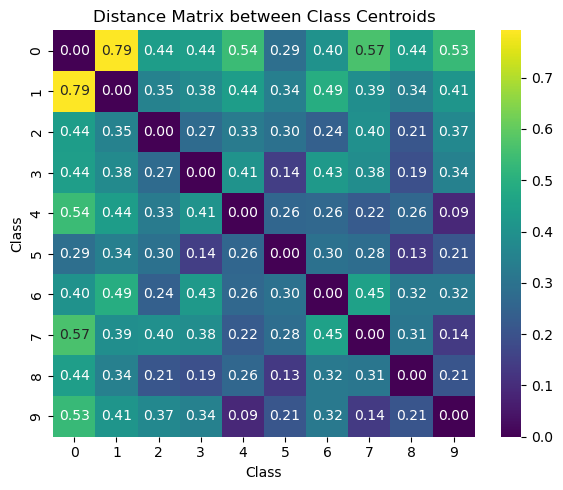

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dist_matrix(test_loader, model=None, device=None):
    if model is None:
        deal_test_loader = test_loader
    else:
        deal_test_loader = deal_dataloader(test_loader, model, device, batch_size = 64)

    features, labels = next(iter(deal_test_loader))
    dims = torch.prod(torch.tensor(features.shape[1:]))

    # 获取 DataLoader 中的全部数据
    deal_test_features = []
    deal_test_labels = []

    for batch_data, batch_labels in deal_test_loader:
        deal_test_features.append(batch_data.view(-1, dims))
        deal_test_labels.append(batch_labels)

    # 合并所有批次
    deal_test_features = torch.cat(deal_test_features, dim=0).numpy()
    deal_test_labels = torch.cat(deal_test_labels, dim=0).numpy()

    # 1. 根据标签分组并求出每一类的均值点
    unique_labels = np.unique(deal_test_labels)
    mean_points = []

    for lbl in unique_labels:
        class_points = deal_test_features[deal_test_labels == lbl]
        mean_point = np.mean(class_points, axis=0)
        mean_points.append(mean_point)

    mean_points = np.vstack(mean_points)  # mean_points 的形状为 (C, D)，C为类的数目

    # 2. 计算距离矩阵（平方距离）
    #   dist[i,j] = \sum (mean_points[i] - mean_points[j])^2
    C = len(unique_labels)
    dist_matrix = np.zeros((C, C))
    for i in range(C):
        for j in range(C):
            diff = mean_points[i] - mean_points[j]
            dist_matrix[i, j] = np.mean(diff * diff)  # 使用平方和作为距离

    # 3. 绘制热力图
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(dist_matrix, annot=True, fmt=".2f", cmap='viridis', 
                    xticklabels=unique_labels, yticklabels=unique_labels)

    ax.set_title("Distance Matrix between Class Centroids")
    ax.set_xlabel("Class")
    ax.set_ylabel("Class")

    plt.tight_layout()
    plt.show()

plot_dist_matrix(test_loader)

# 画出每一类相对于均值的范数分布

Class 0: mean = 22.6069, std = 2.5863
Class 1: mean = 14.9634, std = 3.2799
Class 2: mean = 22.8191, std = 2.4082
Class 3: mean = 21.2232, std = 2.9123
Class 4: mean = 20.4909, std = 2.7968
Class 5: mean = 22.1980, std = 2.4573
Class 6: mean = 21.3305, std = 2.9818
Class 7: mean = 19.4133, std = 3.2948
Class 8: mean = 21.5995, std = 2.8554
Class 9: mean = 19.6115, std = 3.2299


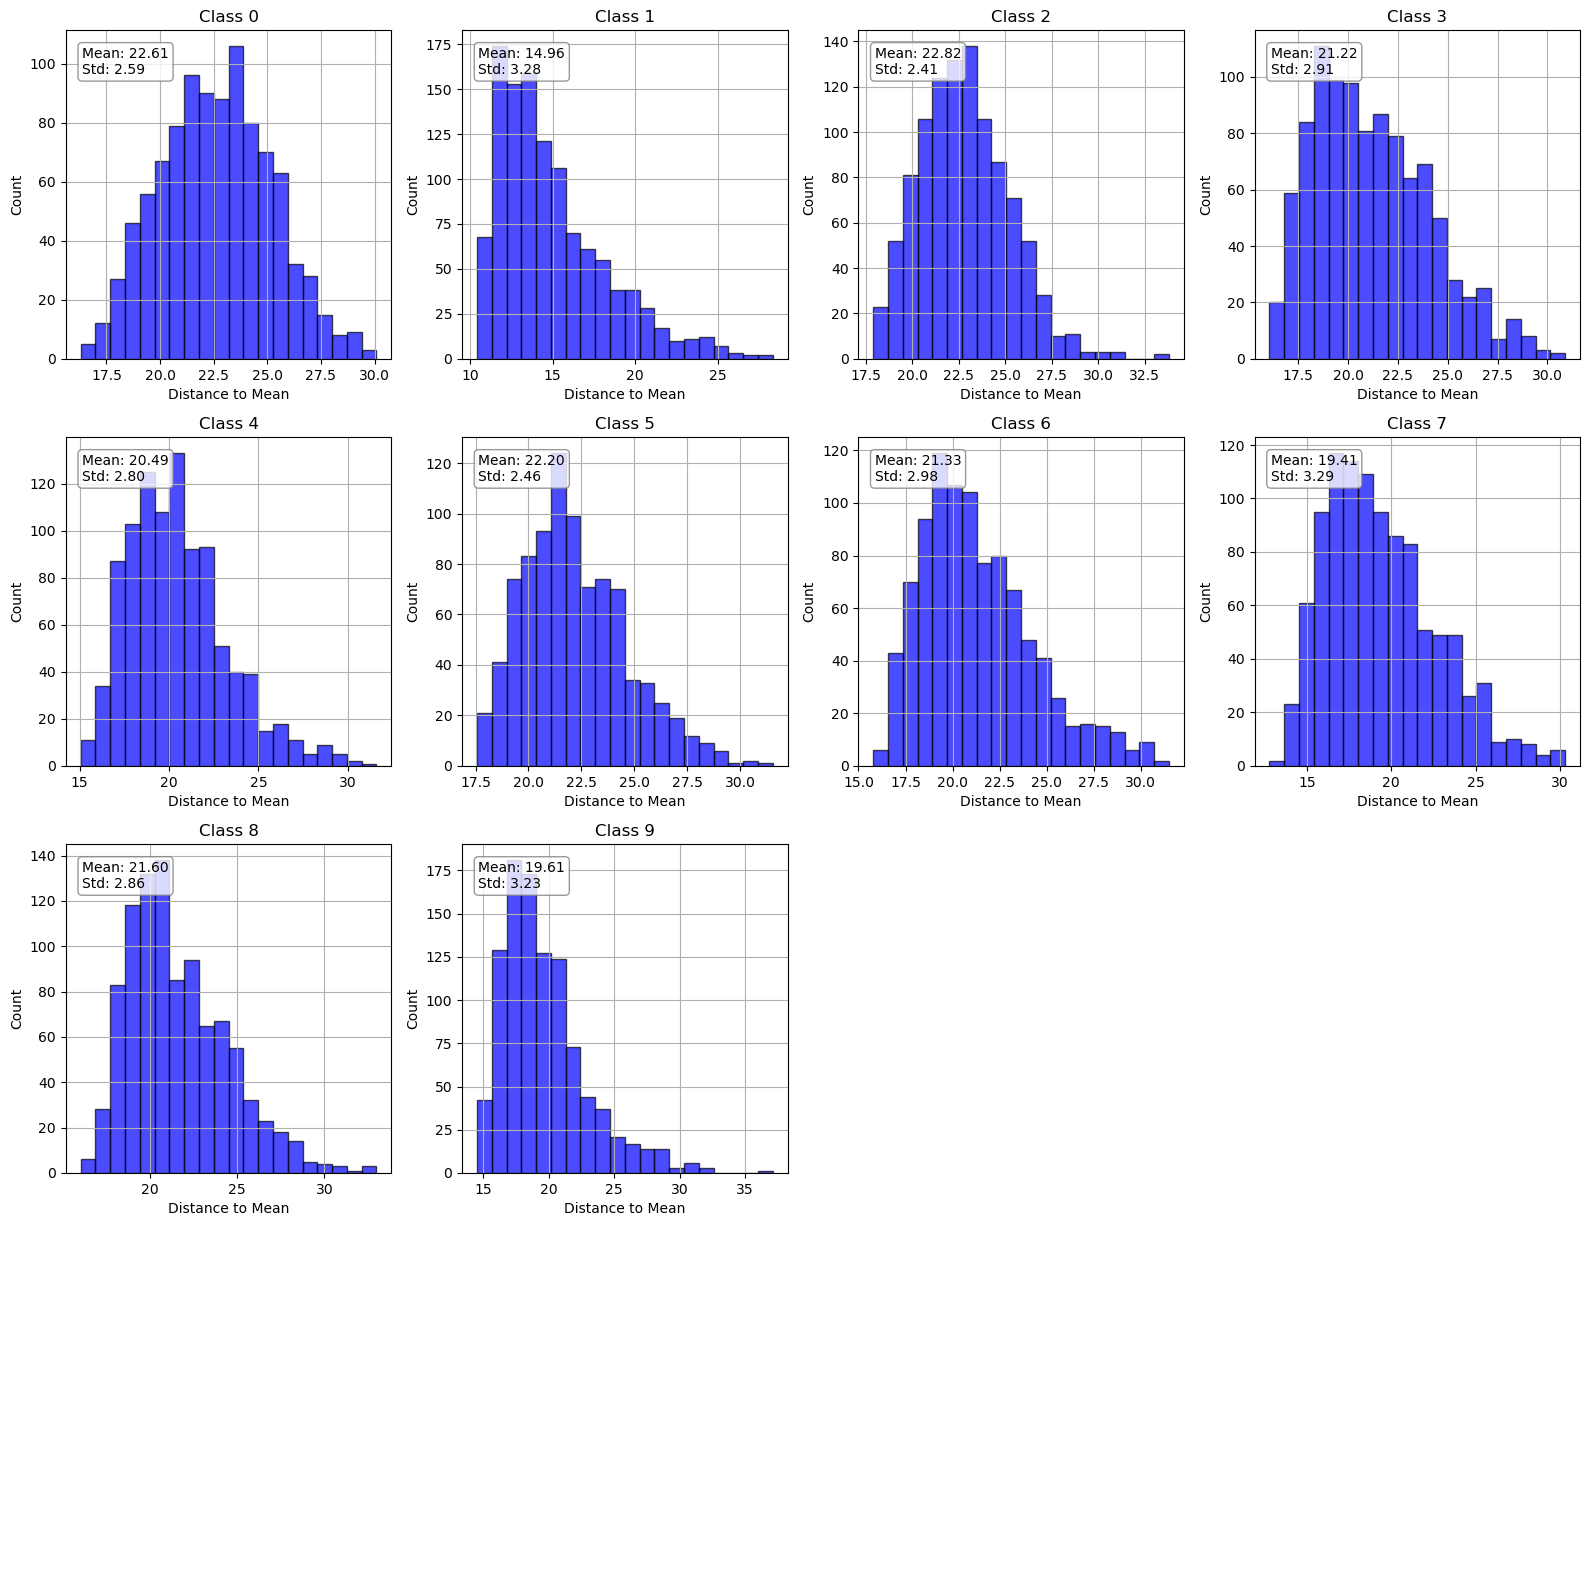

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math

def plot_ever_norm(test_loader, model=None, device=None):
    if model is None:
        deal_test_loader = test_loader
    else:
        deal_test_loader = deal_dataloader(test_loader, model, device, batch_size = 64)

    features, labels = next(iter(deal_test_loader))
    dims = torch.prod(torch.tensor(features.shape[1:]))

    # 获取 DataLoader 中的全部数据
    deal_test_features = []
    deal_test_labels = []

    for batch_data, batch_labels in deal_test_loader:
        deal_test_features.append(batch_data.view(-1, dims))
        deal_test_labels.append(batch_labels)

    # 合并所有批次
    deal_test_features = torch.cat(deal_test_features, dim=0).numpy()
    deal_test_labels = torch.cat(deal_test_labels, dim=0).numpy()

    unique_labels = np.unique(deal_test_labels)
    num_classes = len(unique_labels)

    class_distances = {}
    class_std = {}
    class_mean = {}

    for lbl in unique_labels:
        class_points = deal_test_features[deal_test_labels == lbl]
        mean_point = np.mean(class_points, axis=0)
        dists = np.linalg.norm(class_points - mean_point, axis=1)
        class_distances[lbl] = dists
        class_std[lbl] = np.std(dists)
        class_mean[lbl] = np.mean(dists)

    for lbl in unique_labels:
        print(f"Class {lbl}: mean = {class_mean[lbl]:.4f}, std = {class_std[lbl]:.4f}")

    # 计算n，使子图尽可能接近方阵排列
    n = math.ceil(math.sqrt(num_classes))

    fig, axes = plt.subplots(n, n, figsize=(4*n, 4*n))
    axes = axes.flatten()  # 将子图矩阵展平为一维列表，便于迭代

    # 绘制子图
    for idx, lbl in enumerate(unique_labels):
        ax = axes[idx]
        dist_data = class_distances[lbl]
        ax.hist(dist_data, bins=20, alpha=0.7, color='blue', edgecolor='black')
        ax.set_title(f"Class {lbl}")
        ax.set_xlabel("Distance to Mean")
        ax.set_ylabel("Count")
        ax.grid(True)
        # 标注均值与标准差
        mean_val = class_mean[lbl]
        std_val = class_std[lbl]
        ax.text(0.05, 0.95, f"Mean: {mean_val:.2f}\nStd: {std_val:.2f}", 
                transform=ax.transAxes, verticalalignment='top', fontsize=10, 
                bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.8))

    # 对于多余的子图（如果类数量不是正好n*n），隐藏它们
    for idx in range(num_classes, n*n):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

plot_ever_norm(test_loader)

# 单层网络的准确率

In [7]:
from models.modelset import MLP
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


def MLP_accuracy(train_loader, test_loader, model=None, device=None):
    if model is not None:
        train_loader = deal_dataloader(train_loader, model, device, batch_size = 64)
        test_loader = deal_dataloader(test_loader, model, device, batch_size = 64)
    learning_rate = 0.01
    num_classes = 10
    # 定义损失函数和优化器
    features, labels = next(iter(test_loader))
    images_size = torch.prod(torch.tensor(features.shape[1:]))
    model0 = MLP(images_size, 10).to(device)
    criterion2 = nn.CrossEntropyLoss()  # 使用交叉熵损失
    optimizer = optim.Adam(model0.parameters(), lr=learning_rate)  # 使用随机梯度下降优化器

    model0.train()
    # 训练模型
    epochs = 30
    for epoch in range(epochs):
        for images, labels in train_loader:
            # 将图像展平为一维向量，并将标签进行 one-hot 编码
            images = images.to(device)
            labels_one_hot = F.one_hot(labels, num_classes=num_classes).float().to(device)  # 将标签转换为 one-hot 编码

            # 前向传播
            outputs = model0(images)

            # 计算损失
            loss = criterion2(outputs, labels_one_hot)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # 设置模型为评估模式
    model0.eval()

    # 准确率计数
    correct = 0
    total = 0

    # 禁用梯度计算，加速测试过程
    with torch.no_grad():
        for images, labels in test_loader:
            # 将数据加载到 GPU
            images = images.view(-1, images_size).to(device)
            labels = labels.to(device)

            # 前向传播
            outputs = model0(images)
            
            # 获取预测结果
            _, predicted = torch.max(outputs, 1)
            
            # 更新计数
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 计算准确率
    accuracy = 1.0 * correct / total
    return accuracy

MLP_accuracy(train_loader, test_loader, model=None, device=None)

0.8614

In [8]:
FBDis = fast_FBDistance(test_features, test_labels).numpy()
Boson = FBDis.trace()
Fermi = FBDis.sum() - Boson
print(f"Boson distance={Boson/10}, Fermi distance={Fermi/90}")

Boson distance=0.03704753518104553, Fermi distance=0.021409938070509168


## 绘图

In [9]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 可视化函数：将数据降维到 2D 并可视化
def visualize_2d(features, labels):
    """
    使用 t-SNE 将高维数据降维到 2D 并可视化。
    :param features: 高维特征数据 (tensor or numpy array)
    :param labels: 标签 (tensor or numpy array)
    """
    # 转换为 numpy
    features_np = features.detach().numpy()
    labels_np = labels.numpy()

    # 使用 t-SNE 降维到 2D
    _, dims =features.shape
    
    if dims > 2:
        #tsne = TSNE(n_components=2, random_state=42, perplexity=40)
        pca = PCA(n_components=2)
        features_2d = pca.fit_transform(features_np)
        explained_variance_ratio = pca.explained_variance_ratio_
    else:
        features_2d = features_np
        explained_variance_ratio = None

    # 绘制 2D 散点图
    plt.figure(figsize=(8, 6))
    for label in np.unique(labels):
        mask = labels_np == label
        plt.scatter(
            features_2d[mask, 0],
            features_2d[mask, 1],
            label=f"Class {label}",
            alpha=0.6
        )
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title("Visualization of High-Dimensional Data")
    #plt.legend()
    plt.grid(True)

    # 显示 PCA 信息占比
    if explained_variance_ratio is not None:
        info_text = f"Explained Variance:\nDim 1: {explained_variance_ratio[0]:.2%}\nDim 2: {explained_variance_ratio[1]:.2%}"
        plt.text(0.05, 0.95, info_text, transform=plt.gca().transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.2))

    plt.show()

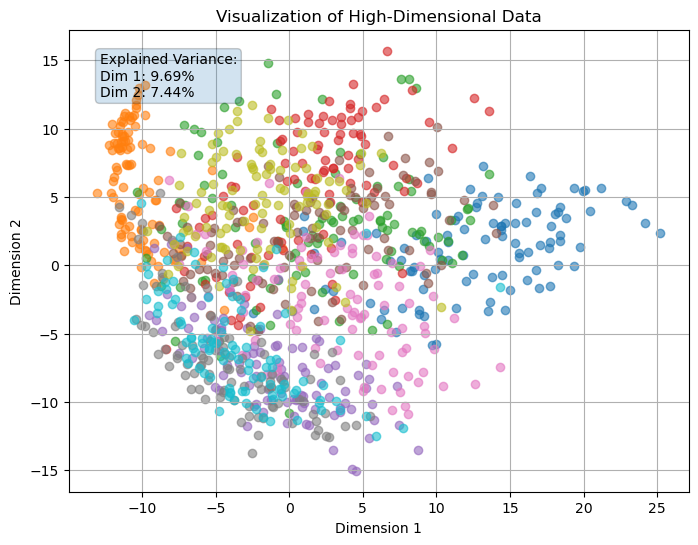

In [10]:
visualize_2d(train_features, train_labels)

# 训练FBM

In [11]:
import torch.optim as optim
import torch.nn.functional as F
from loss.loss import FBMLoss
from models.modelset import FBMLayer
from models.modelset import FBM_KANLayer

# 定义超参数
input_size = images_size
hidden_dim = 1000
num_classes = 10      # MNIST有10个类别
learning_rate = 0.01
num_epochs = 10
batch_size = 64
#alpha = 0.006548084
#df = 1.7666495380528981
df = 0.45
alpha=1.0

#记录训练数据
Boson_list = []
Fermi_list = []
mean_norm_list = []
std_norm_list = []
cluster_accuracy_list = []
MLP_accuracy_list = []

# 实例化模型、定义损失函数和优化器
model = FBMLayer(input_size, hidden_dim).to(device)
#model = FBM_KANLayer(input_size, hidden_dim).to(device)
#criterion = FBMLoss(hidden_dim, 0.01, df, alpha, losstype="fast_StrongInter")
criterion = FBMLoss(hidden_dim, 0.01, df, alpha, losstype="fast_FermiBose")
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
# 训练模型
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # 将图像和标签移动到 GPU 上
        images = images.view(-1, input_size).to(device)  # 展平图像并转移到 GPU
        labels = labels.to(device)  # 标签移动到 GPU
        #labels_one_hot = F.one_hot(labels, num_classes=num_classes).float()
        
        # 前向传播
        outputs = model(images)
        #loss = criterion(outputs, labels_one_hot, model.linear.weight)
        loss = criterion(outputs, labels, model.linear.weight)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    '''
    """分析数据"""
    # 计算距离
    with torch.no_grad():
        deal_features = model(train_features.to(device))
    FBDis = fast_FBDistance(deal_features, train_labels).numpy()
    Boson = FBDis.trace()
    Fermi = FBDis.sum() - Boson
    Boson_list.append(Boson)
    Fermi_list.append(Fermi)
    print(f"Boson distance={Boson}, Fermi distance={Fermi}")

    # 计算范数
    norms = np.linalg.norm(deal_features.cpu().numpy(), axis=1)
    # 统计范数的均值和标准差
    mean_norm_list.append(np.mean(norms))
    std_norm_list.append(np.std(norms))

    # 计算聚类和全连接的准确率
    cluster_accuracy_list.append(cluster_accuracy(test_loader, model=model, device=device))
    MLP_accuracy_list.append(MLP_accuracy(train_loader, test_loader, model=model, device=device))
    '''

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.1404
Epoch [2/10], Loss: 0.1502
Epoch [3/10], Loss: 0.1411
Epoch [4/10], Loss: 0.1324
Epoch [5/10], Loss: 0.1202
Epoch [6/10], Loss: 0.1171
Epoch [7/10], Loss: 0.1261
Epoch [8/10], Loss: 0.1147
Epoch [9/10], Loss: 0.1113
Epoch [10/10], Loss: 0.1274


In [12]:
import matplotlib.pyplot as plt
import numpy as np

'''
x = np.arange(1, num_epochs+1)  # 横坐标为 1 到 epoch

FerBos = []
for i in range(num_epochs):
    FerBos.append(Fermi_list[i]/Boson_list[i])

fig, axes = plt.subplots(2, 3, figsize=(16, 10))  # 创建一个包含2行1列子图的图像

axes[0,0].plot(x, Boson_list, label='Boson', marker='o')  # 绘制第一条曲线
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Distance')
axes[0,0].set_title('Boson distance')
axes[0,0].legend()
axes[0,0].grid(True)

axes[0,1].plot(x, Fermi_list, label='Fermi', marker='^')  # 绘制第二条曲线
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Distance')
axes[0,1].set_title('Fermi distance')
axes[0,1].legend()
axes[0,1].grid(True)

axes[0,2].plot(x, FerBos, label='Fermi/Boson')  # 绘制第三条曲线
axes[0,2].set_xlabel('Epoch')
axes[0,2].set_ylabel('Fermi/Boson')
axes[0,2].set_title('ratio')
axes[0,2].legend()
axes[0,2].grid(True)

axes[1,0].plot(x, mean_norm_list, label='Boson', marker='o')  # 绘制第一条曲线
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('mean')
axes[1,0].set_title('norm mean')
axes[1,0].legend()
axes[1,0].grid(True)

axes[1,1].plot(x, std_norm_list, label='Fermi', marker='^')  # 绘制第二条曲线
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Var')
axes[1,1].set_title('norm var')
axes[1,1].legend()
axes[1,1].grid(True)

axes[1,2].plot(x, cluster_accuracy_list, label='cluster', marker='^')  # 绘制第二条曲线
axes[1,2].plot(x, MLP_accuracy_list, label='MLP', marker='o')  # 绘制第二条曲线
axes[1,2].set_xlabel('Epoch')
axes[1,2].set_ylabel('Accuracy')
axes[1,2].set_title('accuracy')
axes[1,2].legend()
axes[1,2].grid(True)


plt.savefig("./fig.png")

'''


'\nx = np.arange(1, num_epochs+1)  # 横坐标为 1 到 epoch\n\nFerBos = []\nfor i in range(num_epochs):\n    FerBos.append(Fermi_list[i]/Boson_list[i])\n\nfig, axes = plt.subplots(2, 3, figsize=(16, 10))  # 创建一个包含2行1列子图的图像\n\naxes[0,0].plot(x, Boson_list, label=\'Boson\', marker=\'o\')  # 绘制第一条曲线\naxes[0,0].set_xlabel(\'Epoch\')\naxes[0,0].set_ylabel(\'Distance\')\naxes[0,0].set_title(\'Boson distance\')\naxes[0,0].legend()\naxes[0,0].grid(True)\n\naxes[0,1].plot(x, Fermi_list, label=\'Fermi\', marker=\'^\')  # 绘制第二条曲线\naxes[0,1].set_xlabel(\'Epoch\')\naxes[0,1].set_ylabel(\'Distance\')\naxes[0,1].set_title(\'Fermi distance\')\naxes[0,1].legend()\naxes[0,1].grid(True)\n\naxes[0,2].plot(x, FerBos, label=\'Fermi/Boson\')  # 绘制第三条曲线\naxes[0,2].set_xlabel(\'Epoch\')\naxes[0,2].set_ylabel(\'Fermi/Boson\')\naxes[0,2].set_title(\'ratio\')\naxes[0,2].legend()\naxes[0,2].grid(True)\n\naxes[1,0].plot(x, mean_norm_list, label=\'Boson\', marker=\'o\')  # 绘制第一条曲线\naxes[1,0].set_xlabel(\'Epoch\')\naxes[1,0]

# 观察分类完之后的数据分布

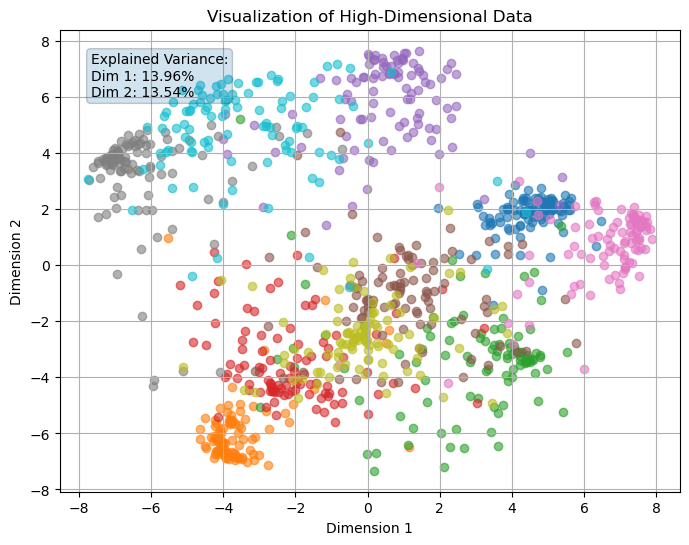

In [13]:
with torch.no_grad():
    out_features = model(train_features.to(device)).cpu()
visualize_2d(out_features, train_labels)

# 计算距离矩阵

Processed data shape: torch.Size([10000, 500])


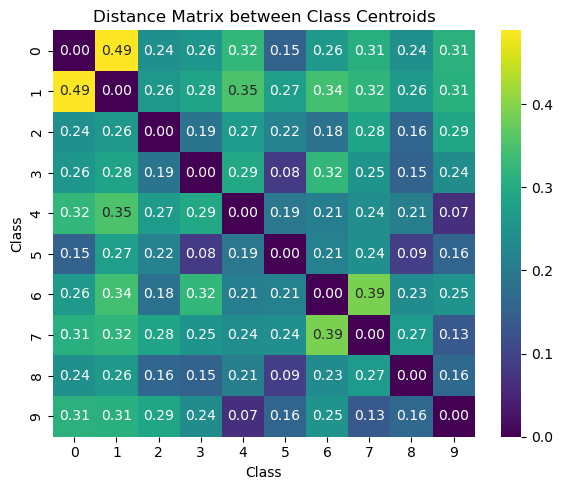

In [14]:
plot_dist_matrix(test_loader, model=model, device=device)

# 绘制范数分布

Processed data shape: torch.Size([10000, 500])
Class 0: mean = 5.8755, std = 1.7754
Class 1: mean = 4.9839, std = 1.9842
Class 2: mean = 7.7552, std = 1.7326
Class 3: mean = 7.6534, std = 1.7140
Class 4: mean = 7.6955, std = 1.4217
Class 5: mean = 9.0005, std = 1.2678
Class 6: mean = 6.6840, std = 2.0823
Class 7: mean = 6.6011, std = 2.4083
Class 8: mean = 8.2752, std = 1.6312
Class 9: mean = 8.0596, std = 1.5654


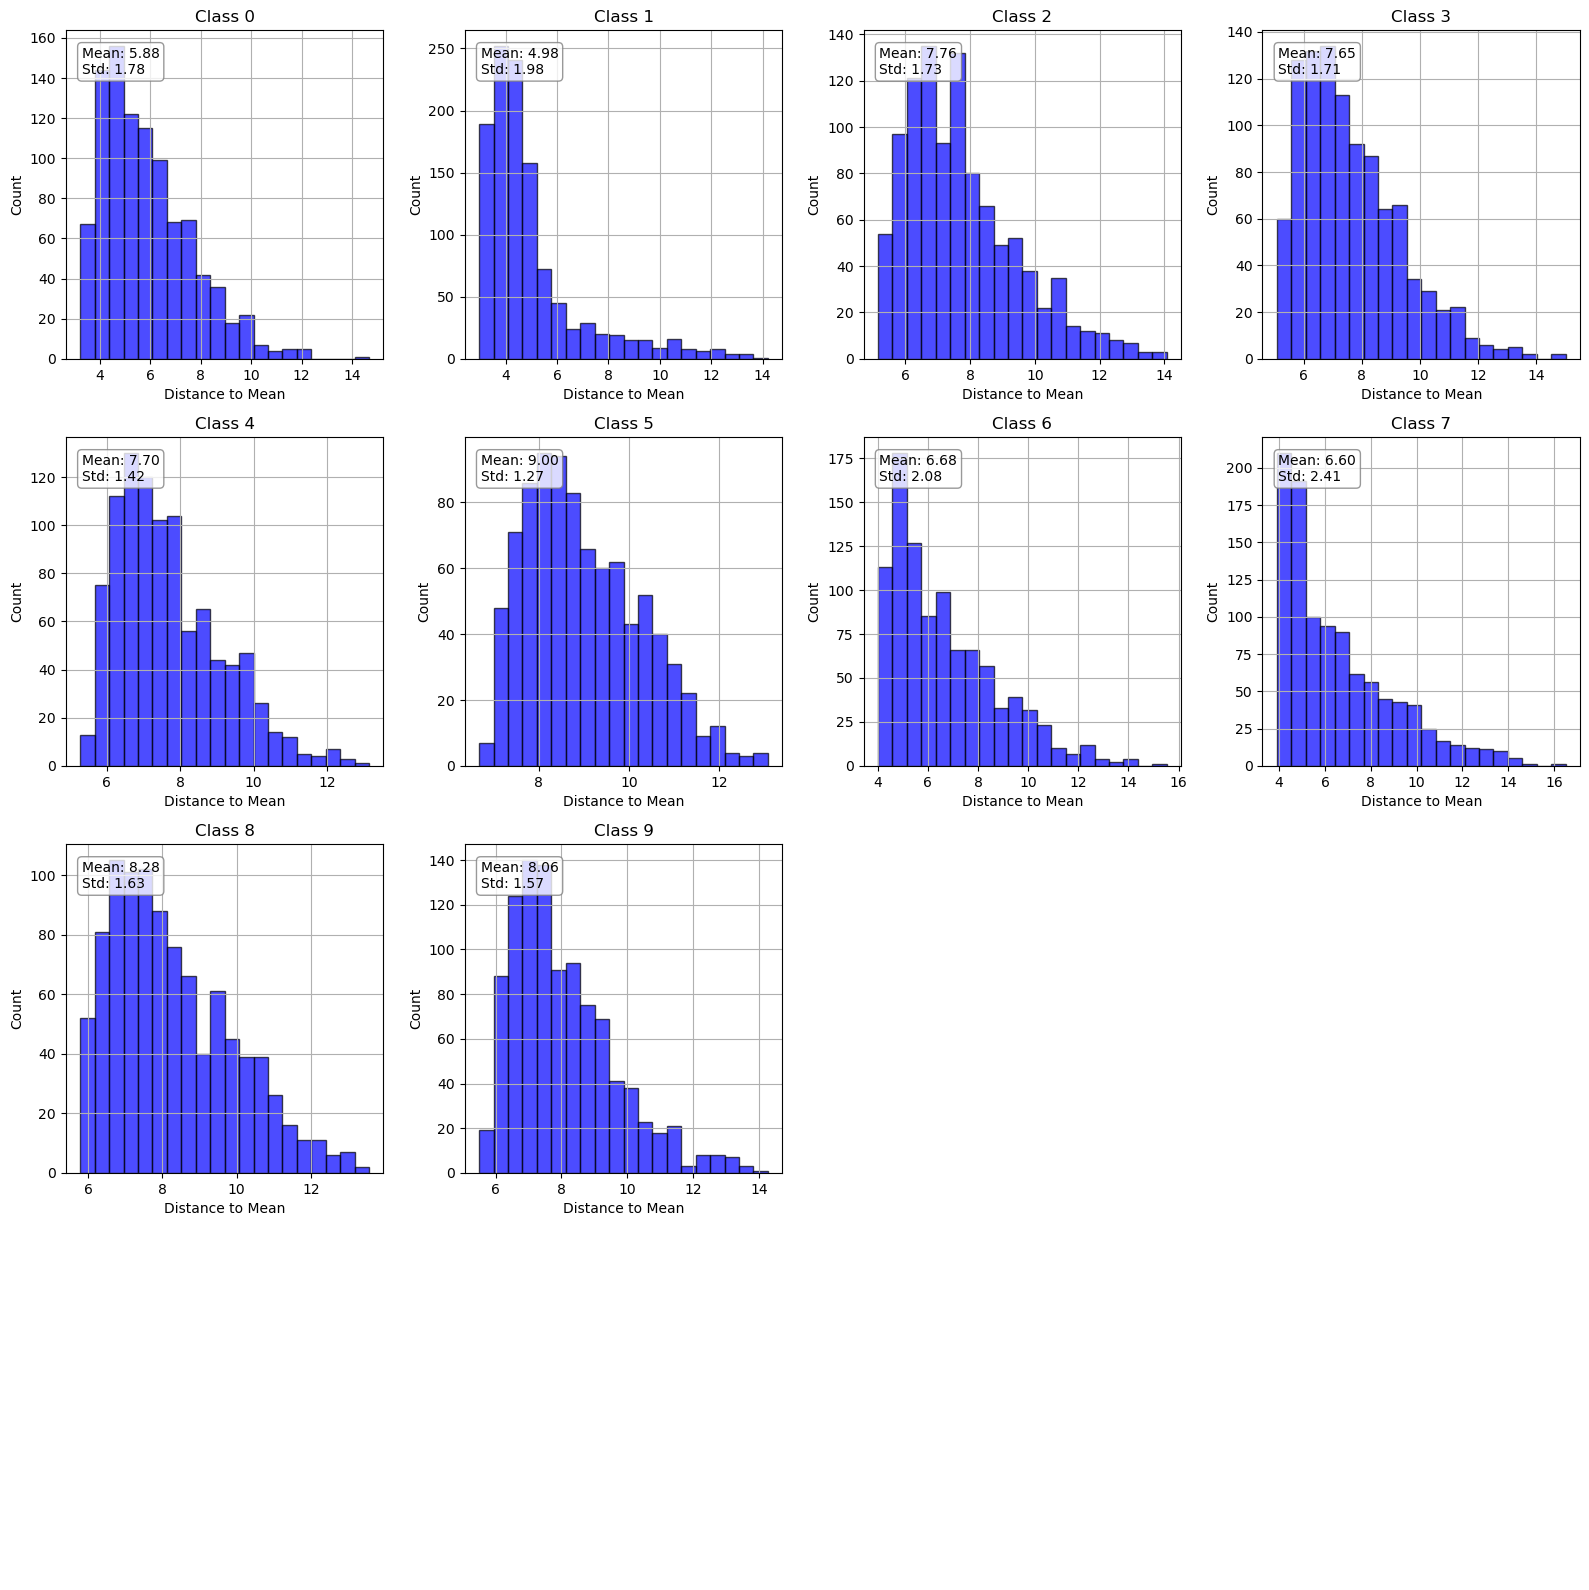

In [15]:
plot_ever_norm(test_loader, model=model, device=device)

# 计算处理之后的聚类结果

In [16]:
deal_test_loader = deal_dataloader(test_loader, model, device, batch_size = 64)
# 获取 DataLoader 中的全部数据
deal_test_features = []
deal_test_labels = []

for batch_data, batch_labels in deal_test_loader:
    deal_test_features.append(batch_data.view(-1, hidden_dim))
    deal_test_labels.append(batch_labels)

# 合并所有批次
deal_test_features = torch.cat(deal_test_features, dim=0)
deal_test_labels = torch.cat(deal_test_labels, dim=0)

data = deal_test_features.numpy()  # 展平
labels = deal_test_labels.numpy()
print(labels.shape)

# 2. 应用KMeans聚类
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_assignments = kmeans.fit_predict(data)

# 3. 创建混淆矩阵
confusion_matrix = np.zeros((n_clusters, 10), dtype=np.int32)
for cluster in range(n_clusters):
    cluster_labels = labels[cluster_assignments == cluster]
    for label in range(10):
        confusion_matrix[cluster, label] = np.sum(cluster_labels == label)

print("混淆矩阵：")
print(confusion_matrix)

# 4. 使用匈牙利算法找到最佳标签分配
# 我们需要最大化正确分类，因此将混淆矩阵取负作为成本矩阵
cost_matrix = -confusion_matrix
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# 创建标签映射
cluster_to_label = {}
for cluster, label in zip(row_ind, col_ind):
    cluster_to_label[cluster] = label

print("\n聚类到标签的映射：")
for cluster in cluster_to_label:
    print(f"聚类 {cluster} -> 标签 {cluster_to_label[cluster]}")

# 5. 使用映射分配标签并计算准确率
predicted_labels = np.array([cluster_to_label[cluster] for cluster in cluster_assignments])
accuracy = accuracy_score(labels, predicted_labels)
print(f"\n分类准确率: {accuracy * 100:.2f}%")

Processed data shape: torch.Size([10000, 500])
(10000,)


/home/yixiong_ren/anaconda3/envs/normal/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


混淆矩阵：
[[   0    1    0    3  196    9    0   50   24  699]
 [   3   23   37   29    4   22    1    4  763    2]
 [   0    3   15  853    0   72    1    3   38   11]
 [   0 1090   11    3    1    4    6   27    8    4]
 [   7    3    2   65    0  693   24    1   60   12]
 [   3   10  897   31    4    8   23   31   18    5]
 [   1    1   21    0  744   22   19   12   14  213]
 [   3    4   24    3   30   21  861    1   23    5]
 [ 962    0   12    6    2   28   23    5   10   15]
 [   1    0   13   17    1   13    0  894   16   43]]

聚类到标签的映射：
聚类 0 -> 标签 9
聚类 1 -> 标签 8
聚类 2 -> 标签 3
聚类 3 -> 标签 1
聚类 4 -> 标签 5
聚类 5 -> 标签 2
聚类 6 -> 标签 4
聚类 7 -> 标签 6
聚类 8 -> 标签 0
聚类 9 -> 标签 7

分类准确率: 84.56%


In [17]:
from models.modelset import MLP
import torch.nn as nn

deal_train_loader = deal_dataloader(train_loader, model, device, batch_size = 64)

# 定义损失函数和优化器
model2 = MLP(hidden_dim, num_classes).to(device)
criterion2 = nn.CrossEntropyLoss()  # 使用交叉熵损失
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)  # 使用随机梯度下降优化器

model2.train()
# 训练模型
epochs = 30
for epoch in range(epochs):
    for images, labels in deal_train_loader:
        # 将图像展平为一维向量，并将标签进行 one-hot 编码
        images = images.to(device)
        labels_one_hot = F.one_hot(labels, num_classes=num_classes).float().to(device)  # 将标签转换为 one-hot 编码

        # 前向传播
        outputs = model2(images)

        # 计算损失
        loss = criterion2(outputs, labels_one_hot)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 设置模型为评估模式
model2.eval()

# 准确率计数
correct = 0
total = 0

# 禁用梯度计算，加速测试过程
with torch.no_grad():
    for images, labels in deal_test_loader:
        # 将数据加载到 GPU
        images = images.view(-1, hidden_dim).to(device)
        labels = labels.to(device)

        # 前向传播
        outputs = model2(images)
        
        # 获取预测结果
        _, predicted = torch.max(outputs, 1)
        
        # 更新计数
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 计算准确率
accuracy = 1.0 * correct / total
print(accuracy)

Processed data shape: torch.Size([1000, 500])


0.8847


$\text{Loss}=\delta_{AB}\text{ReLu}(D-\frac{df}{10})+(1-\delta_{AB})\text{ReLu}(df-D)$